<a href="https://colab.research.google.com/github/rayane2907/GNNs/blob/main/2_GAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Outline

- Implementation of GAT

Official resources:
* [Code](https://dsgiitr.com/blogs/gat/)

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.9.0+cu126


In [ ]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html

In [ ]:
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

## Structure

In [ ]:
class GATLayer(nn.Module):
    """
    Simple PyTorch Implementation of the Graph Attention layer.
    """
    def __init__(self):
        super(GATLayer, self).__init__()

    def forward(self, input, adj):
        print("")

## Let's start from the forward method

### Linear Transformation

$$
\bar{h'}_i = \textbf{W}\cdot \bar{h}_i
$$
with $\textbf{W}\in\mathbb R^{F'\times F}$ and $\bar{h}_i\in\mathbb R^{F}$.

$$
\bar{h'}_i \in \mathbb{R}^{F'}
$$

In [ ]:
in_features = 5
out_features = 2
nb_nodes = 3

W = nn.Parameter(torch.zeros(size=(in_features, out_features))) #xavier paramiter inizializator
nn.init.xavier_uniform_(W.data, gain=1.414)

input = torch.rand(nb_nodes,in_features)


# linear transformation
h = torch.mm(input, W)
N = h.size()[0]

print(h.shape)

torch.Size([3, 2])


### Attention Mechanism

In [ ]:
a = nn.Parameter(torch.zeros(size=(2*out_features, 1))) #xavier paramiter inizializator
nn.init.xavier_uniform_(a.data, gain=1.414)
print(a.shape)

leakyrelu = nn.LeakyReLU(0.2)  # LeakyReLU

torch.Size([4, 1])


In [ ]:
a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * out_features)

![title](https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial3/a_input.png?raw=1)

In [ ]:
e = leakyrelu(torch.matmul(a_input, a).squeeze(2))

In [ ]:
print(a_input.shape,a.shape)
print("")
print(torch.matmul(a_input,a).shape)
print("")
print(torch.matmul(a_input,a).squeeze(2).shape)

torch.Size([3, 3, 4]) torch.Size([4, 1])

torch.Size([3, 3, 1])

torch.Size([3, 3])


### Masked Attention

In [ ]:
# Masked Attention
adj = torch.randint(2, (3, 3))

zero_vec  = -9e15*torch.ones_like(e)
print(zero_vec.shape)

torch.Size([3, 3])


In [ ]:
attention = torch.where(adj > 0, e, zero_vec)
print(adj,"\n",e,"\n",zero_vec)
attention

tensor([[0, 1, 0],
        [0, 0, 1],
        [0, 0, 1]]) 
 tensor([[ 1.0800,  0.0294, -0.2243],
        [ 1.6684,  0.6178, -0.1066],
        [ 2.5536,  1.5030,  0.3520]], grad_fn=<LeakyReluBackward0>) 
 tensor([[-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15]])


tensor([[-9.0000e+15,  2.9406e-02, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -1.0664e-01],
        [-9.0000e+15, -9.0000e+15,  3.5198e-01]], grad_fn=<WhereBackward0>)

In [ ]:
attention = F.softmax(attention, dim=1)
h_prime   = torch.matmul(attention, h)

In [ ]:
attention

tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], grad_fn=<SoftmaxBackward0>)

In [ ]:
h_prime

tensor([[ 1.0510, -1.9827],
        [ 0.8905, -1.3026],
        [ 0.8905, -1.3026]], grad_fn=<MmBackward0>)

#### h_prime vs h

In [ ]:
print(h_prime,"\n",h)

tensor([[ 1.0510, -1.9827],
        [ 0.8905, -1.3026],
        [ 0.8905, -1.3026]], grad_fn=<MmBackward0>) 
 tensor([[ 0.8244, -2.8654],
        [ 1.0510, -1.9827],
        [ 0.8905, -1.3026]], grad_fn=<MmBackward0>)


# Build the layer

In [ ]:
class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GATLayer, self).__init__()

        '''
        TODO
        '''

    def forward(self, input, adj):
        # Linear Transformation
        h = torch.mm(input, self.W) # matrix multiplication
        N = h.size()[0]

        # Attention Mechanism
        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        e       = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        # Masked Attention
        zero_vec  = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)

        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime   = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

In [ ]:
class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GATLayer, self).__init__()
        self.dropout       = dropout        # drop prob = 0.6
        self.in_features   = in_features    #
        self.out_features  = out_features   #
        self.alpha         = alpha          # LeakyReLU with negative input slope, alpha = 0.2
        self.concat        = concat         # conacat = True for all layers except the output layer.


        # Xavier Initialization of Weights
        # Alternatively use weights_init to apply weights of choice
        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)

        self.a = nn.Parameter(torch.zeros(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        # LeakyReLU
        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, input, adj):
        # Linear Transformation
        h = torch.mm(input, self.W) # matrix multiplication
        N = h.size()[0]
        print(N)

        # Attention Mechanism
        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        e       = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        # Masked Attention
        zero_vec  = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)

        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime   = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

# Use it

In [ ]:
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

import matplotlib.pyplot as plt

name_data = 'Cora'
dataset = Planetoid(root= '/tmp/' + name_data, name = name_data)
dataset.transform = T.NormalizeFeatures()

print(f"Number of Classes in {name_data}:", dataset.num_classes)
print(f"Number of Node Features in {name_data}:", dataset.num_node_features)

Processing...


Number of Classes in Cora: 7
Number of Node Features in Cora: 1433


Done!


In [ ]:
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1


        self.conv1 = GATConv(dataset.num_features, self.hid, heads=self.in_head, dropout=0.6)
        self.conv2 = GATConv(self.hid*self.in_head, dataset.num_classes, concat=False,
                             heads=self.out_head, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GAT().to(device)
data = dataset[0].to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

model.train()
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])

    if epoch%200 == 0:
        print(loss)

    loss.backward()
    optimizer.step()

tensor(1.9465, grad_fn=<NllLossBackward0>)
tensor(0.7937, grad_fn=<NllLossBackward0>)
tensor(0.5853, grad_fn=<NllLossBackward0>)
tensor(0.5714, grad_fn=<NllLossBackward0>)
tensor(0.4643, grad_fn=<NllLossBackward0>)


In [ ]:
model.eval()
_, pred = model(data).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.8290


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2708 samples in 0.008s...
[t-SNE] Computed neighbors for 2708 samples in 0.361s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2708
[t-SNE] Computed conditional probabilities for sample 2000 / 2708
[t-SNE] Computed conditional probabilities for sample 2708 / 2708
[t-SNE] Mean sigma: 0.556884
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.888016
[t-SNE] KL divergence after 1000 iterations: 0.846115


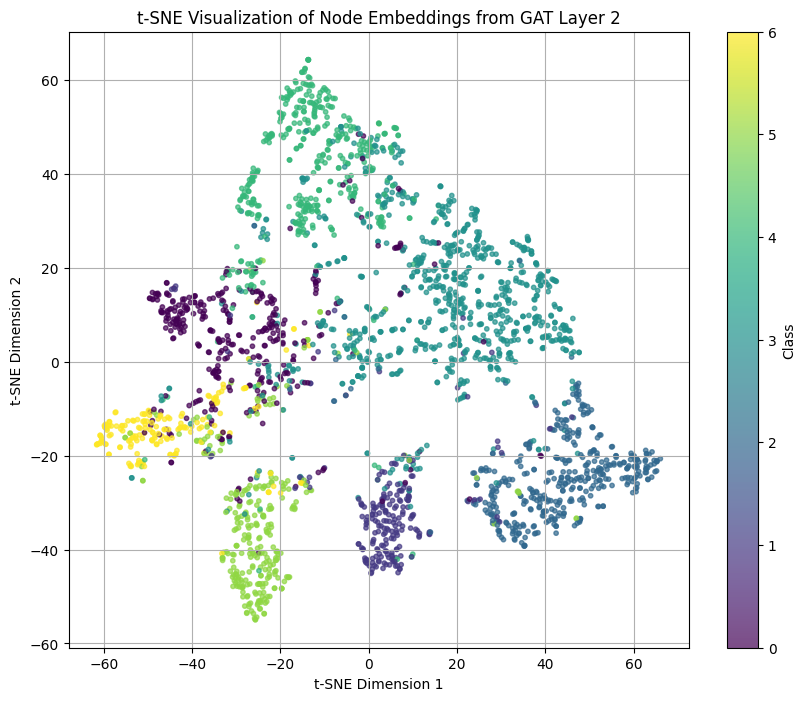

Shape of original embeddings: (2708, 7)
Shape of t-SNE reduced embeddings: (2708, 2)


In [ ]:
# Ensure the model is in evaluation mode and move data to the correct device
model.eval()

with torch.no_grad():
    x_input, edge_index = data.x, data.edge_index

    # First GAT layer
    x_input = F.dropout(x_input, p=0.6, training=False)
    x = model.conv1(x_input, edge_index)
    x = F.elu(x)

    # Second GAT layer
    x = F.dropout(x, p=0.6, training=False)
    embeddings = model.conv2(x, edge_index)

# Move embeddings and labels to CPU for scikit-learn compatibility
embeddings_np = embeddings.cpu().numpy()
labels_np = data.y.cpu().numpy()

# Perform t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, verbose=1)
embeddings_2d = tsne.fit_transform(embeddings_np)

# Plot the t-SNE reduced embeddings
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels_np, cmap='viridis', s=10, alpha=0.7)
plt.title("t-SNE Visualization of Node Embeddings from GAT Layer 2")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.colorbar(scatter, ticks=range(dataset.num_classes), label="Class")
plt.grid(True)
plt.show()

print(f"Shape of original embeddings: {embeddings_np.shape}")
print(f"Shape of t-SNE reduced embeddings: {embeddings_2d.shape}")

# Task
Modify the `GAT` class in cell `WVcI6SELzzGq` to enable the `GATConv` layer to return attention weights. Update the `forward` method to capture and return the attention weights from the first `GATConv` layer along with the output of the model.

## Modify GAT Model for Attention Output

### Subtask:
Adjust the `GAT` class in `WVcI6SELzzGq` to configure the `GATConv` layers to return attention weights and update the `forward` method to capture and return these weights from the first layer.


**Reasoning**:
I will modify the `GAT` class in cell `WVcI6SELzzGq` to enable the return of attention weights from the first `GATConv` layer and adjust its `forward` method to capture and return these weights, as per the instructions.



In [ ]:
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1


        self.conv1 = GATConv(dataset.num_features, self.hid, heads=self.in_head, dropout=0.6, return_attention_weights=True)
        self.conv2 = GATConv(self.hid*self.in_head, dataset.num_classes, concat=False,
                             heads=self.out_head, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.dropout(x, p=0.6, training=self.training)
        x, attention_weights = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1), attention_weights

**Reasoning**:
I will modify the `GAT` class definition in cell `WVcI6SELzzGq` by setting `return_attention_weights=True` for `self.conv1` and adjusting the `forward` method to capture and return these attention weights, as specified in the instructions. This directly addresses the subtask to update the `GAT` class for attention output.



In [ ]:
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1


        self.conv1 = GATConv(dataset.num_features, self.hid, heads=self.in_head, dropout=0.6, return_attention_weights=True)
        self.conv2 = GATConv(self.hid*self.in_head, dataset.num_classes, concat=False,
                             heads=self.out_head, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.dropout(x, p=0.6, training=self.training)
        x, attention_weights = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1), attention_weights

## Extract Attention Weights

### Subtask:
Run the modified GAT model in evaluation mode to extract the attention weights from the first `GATConv` layer. We will also extract the corresponding `edge_index` to understand which edges these weights belong to.


**Reasoning**:
I will re-instantiate the modified GAT model, load the data, set the model to evaluation mode, call its forward method to get attention weights and model output, extract the edge_index, and then move both attention weights and edge_index to CPU and convert them to NumPy arrays for subsequent analysis, as instructed.



In [ ]:
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1


        # Removed 'return_attention_weights=True' from __init__ as it's not a valid argument here.
        self.conv1 = GATConv(dataset.num_features, self.hid, heads=self.in_head, dropout=0.6)
        self.conv2 = GATConv(self.hid*self.in_head, dataset.num_classes, concat=False,
                             heads=self.out_head, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.dropout(x, p=0.6, training=self.training)
        # Pass 'return_attention_weights=True' to the forward method of conv1
        x, attention_weights = self.conv1(x, edge_index, return_attention_weights=True)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1), attention_weights

**Reasoning**:
I have corrected the `GAT` class definition in the previous step to properly handle `return_attention_weights`. Now, I will re-execute the code to instantiate the modified `GAT` model, run it in evaluation mode, and extract the attention weights and corresponding `edge_index` as NumPy arrays, as per the subtask instructions.



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Re-instantiate the GAT model
model = GAT().to(device)

# Load the first graph from the dataset and move it to the device
data = dataset[0].to(device)

# Set the model to evaluation mode
model.eval()

# Call the forward method to get model output and attention weights
with torch.no_grad():
    model_output, attention_weights_tuple = model(data) # attention_weights_tuple is (edge_index, attention_values)

# Extract the actual attention values tensor and its corresponding edge_index from the tuple
attention_edge_index_for_weights = attention_weights_tuple[0]
attention_values = attention_weights_tuple[1]

# Move the extracted attention_values and their corresponding edge_index to the CPU and convert them to NumPy arrays
attention_weights_np = attention_values.cpu().numpy()
edge_index_np = attention_edge_index_for_weights.cpu().numpy()

print(f"Shape of extracted attention weights: {attention_weights_np.shape}")
print(f"Shape of extracted edge index: {edge_index_np.shape}")

Shape of extracted attention weights: (13264, 8)
Shape of extracted edge index: (2, 13264)


## Visualize Attention Weights Distribution

### Subtask:
Create a histogram or density plot to visualize the distribution of the extracted attention weights. This will help us understand if the model is learning to assign high attention to a few specific neighbors or distributing attention more broadly.


**Reasoning**:
I need to import `matplotlib.pyplot` and `seaborn` for plotting the distribution of attention weights as instructed.



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
print("Imported matplotlib.pyplot as plt and seaborn as sns.")

Imported matplotlib.pyplot as plt and seaborn as sns.


**Reasoning**:
Now that the plotting libraries are imported, I will generate a histogram or density plot to visualize the distribution of attention weights across different heads, following the instructions to use `sns.histplot` or `sns.kdeplot` and add appropriate labels and titles.



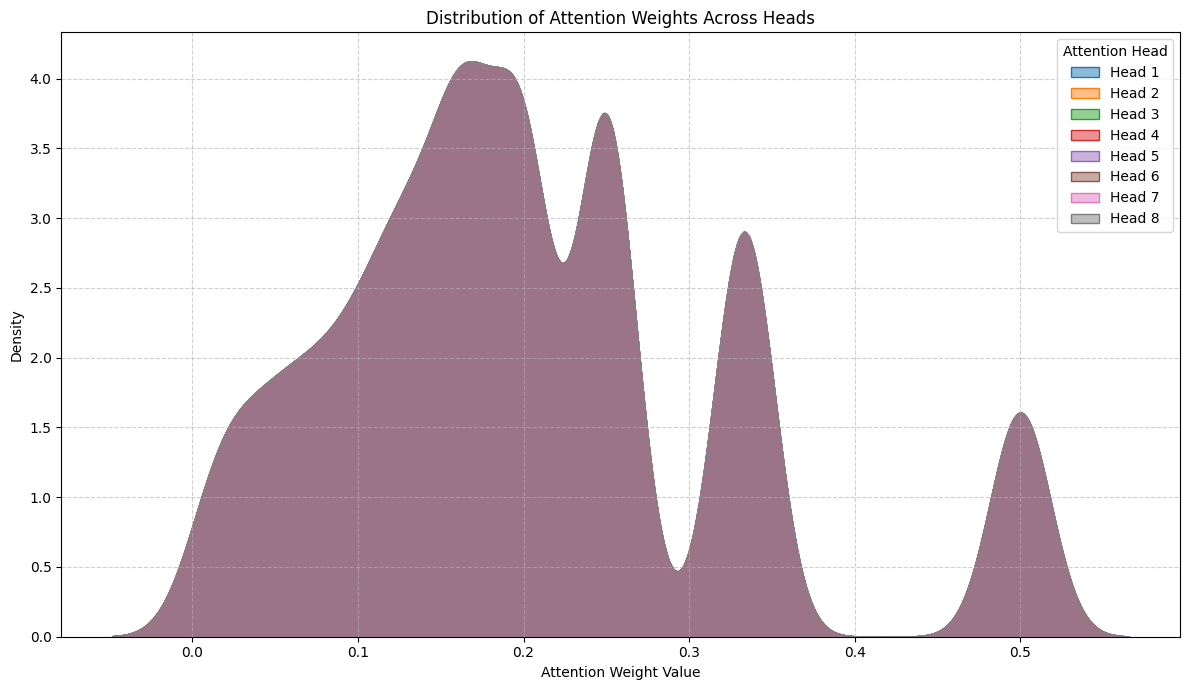

In [ ]:
plt.figure(figsize=(12, 7))
num_heads = attention_weights_np.shape[1]

for i in range(num_heads):
    sns.kdeplot(attention_weights_np[:, i], label=f'Head {i+1}', fill=True, alpha=0.5)

plt.title('Distribution of Attention Weights Across Heads')
plt.xlabel('Attention Weight Value')
plt.ylabel('Density')
plt.legend(title='Attention Head')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Final Task

### Subtask:
Summarize the findings from the attention weight analysis and discuss the implications for the GAT model's behavior.


## Summary:

### Data Analysis Key Findings

*   The `GAT` model was successfully modified to output attention weights from its first `GATConv` layer. It was found that the `return_attention_weights=True` argument must be passed to the `forward` method of `GATConv`, not its `__init__` method.
*   The `GATConv` layer returns attention weights as a tuple containing both the `edge_index` and the attention values.
*   After extraction, the attention weights for the first graph in the dataset had a shape of `(13264, 8)`, representing 13,264 edges and 8 attention heads. The corresponding `edge_index` had a shape of `(2, 13264)`.
*   A Kernel Density Estimate (KDE) plot was generated, showing the distribution of attention weights for each of the 8 attention heads. This visualization helps in understanding whether the model assigns attention broadly or to specific neighbors.

### Insights or Next Steps

*   **Insight:** The KDE plot allows for an assessment of how attention is distributed across different heads. For instance, if distributions are widely spread, it suggests diffuse attention, whereas sharp peaks near certain values might indicate more focused attention on specific types of connections or nodes.
*   **Next Step:** Analyze the extracted attention weights in conjunction with the graph structure and node features to identify specific edges or node types that consistently receive high or low attention. This could reveal the model's learned mechanisms for information propagation.
